In [1]:
%reset -s -f
#%run helpers.ipynb

In [2]:
import logging
import os

import torch
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import pyro
import graphviz
import pyro.distributions as dist
import pyro.distributions.constraints as constraints

In [3]:
smoke_test = ('CI' in os.environ)
assert pyro.__version__.startswith('1.8.4')

pyro.enable_validation(True)
pyro.set_rng_seed(1)
logging.basicConfig(format='%(message)s', level=logging.INFO)

# Set matplotlib settings
%matplotlib inline
plt.style.use('default')

In [4]:
# Returns list of normally-distributed variables with means from dictionary d and constant variance "variance"
def normal_variables_from_dict(d, variance):
    var_dict = {}
    for key in d.keys():
        var_dict[key] = pyro.sample(key, dist.Normal(d[key], variance))
    return var_dict

In [5]:
def model(sample_list, drug_list, obs_list, sample_means, drug_means):
    num_observations = len(obs_list)
    assert len(sample_list) == num_observations
    assert len(drug_list) == num_observations
    # create variables for each sample and drug
    samples = normal_variables_from_dict(sample_means, 1)
    drugs = normal_variables_from_dict(drug_means, 1)
    # create variable for each (sample, drug) pair observed
    sigma = pyro.param("sigma", lambda: torch.ones(()), constraint=constraints.positive)
    for i in pyro.plate("data", num_observations):
        name = sample_list[i] + '_' + drug_list[i]
        mean = samples[sample_list[i]] * drugs[drug_list[i]]
        pyro.sample(name, dist.Normal(mean, sigma), obs=obs_list[i])

In [6]:
# given dataframe with columns 'sample', 'drug', and 'log(V_V0)_obs', return lists to pass to model
def format_for_model(d, vol_name):
    sample_list = list(d['sample'])
    drug_list = list(d['drug'])
    obs_list = []
    for obs in d[vol_name]:
        obs_list.append(torch.Tensor(obs))
    return sample_list, drug_list, obs_list

In [ ]:
t_data = {'sample': ['s0', 's0', 's1', 's1'], 
          'drug': ['d0', 'd1', 'd0', 'd1'], 
          'log(V_V0)_obs': [[3, 3.1], [4, 4.2], [6, 5.9], [8]] }
df = pd.DataFrame.from_dict(t_data)
df

In [8]:
def get_means(var_list):
    means = {}
    for v in var_list:
        means[v] = 0
    return means

In [9]:
df = pd.read_pickle('data/split/train.pkl')
vol_name = 'log(V_V0+1)_obs'
sample_means = get_means(df['sample'].unique())
drug_means = get_means(df['drug'].unique())
sample_list, drug_list, obs_list = format_for_model(df, vol_name)

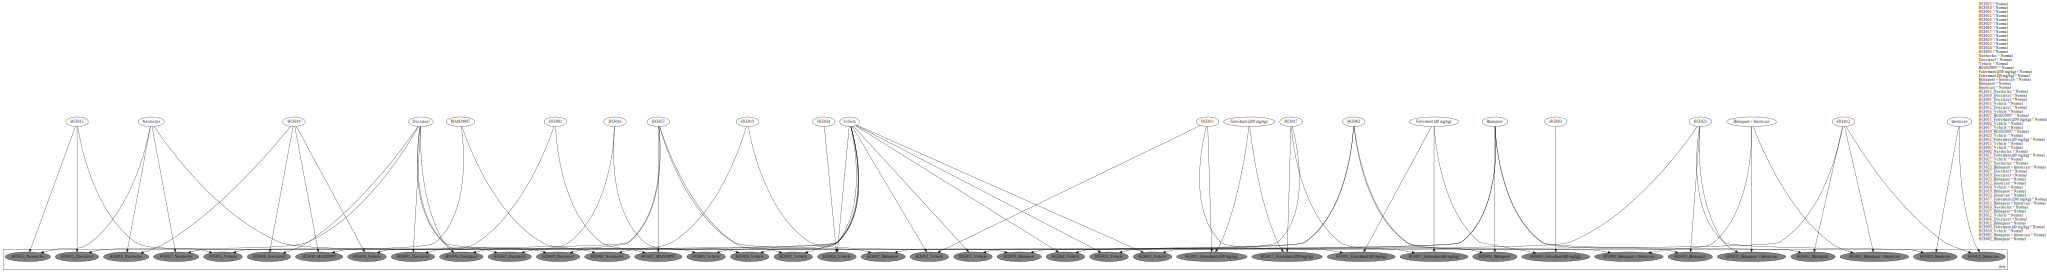

In [10]:
pyro.render_model(model, 
                  model_args=(sample_list, drug_list, obs_list, sample_means, drug_means), 
                  render_distributions=True)

In [ ]:
# Generate data
sample_list = ['s0', 's0', 's1', 's1']
drug_list = ['d0', 'd1', 'd0', 'd1']
obs_list = [torch.Tensor([3, 3.1]), torch.Tensor([4, 4.2]), torch.Tensor([6, 5.9]), torch.Tensor([8])]
sample_means = {'s0': 1, 's1': 2}
drug_means = {'d0': 3, 'd1': 4}

In [11]:
pyro.clear_param_store()
kernel = pyro.infer.mcmc.NUTS(model, jit_compile=True)
mcmc = pyro.infer.MCMC(kernel, num_samples=500, warmup_steps=500)
mcmc.run(sample_list, drug_list, obs_list, sample_means, drug_means)

Warmup:   0%|                                            | 0/1000 [00:00, ?it/s]/Users/michelameister/opt/anaconda3/lib/python3.8/site-packages/pyro/poutine/indep_messenger.py:108: TracerWarning: Iterating over a tensor might cause the trace to be incorrect. Passing a tensor of different shape won't change the number of iterations executed (and might lead to errors or silently give incorrect results).
  for i in self.indices:
/Users/michelameister/opt/anaconda3/lib/python3.8/site-packages/pyro/poutine/indep_messenger.py:111: TracerWarning: Converting a tensor to a Python number might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This means that the trace might not generalize to other inputs!
  yield i if isinstance(i, numbers.Number) else i.item()
/Users/michelameister/opt/anaconda3/lib/python3.8/site-packages/pyro/poutine/indep_messenger.py:111: TracerWarning: Converting a tensor to a Python 

/Users/michelameister/opt/anaconda3/lib/python3.8/site-packages/pyro/poutine/subsample_messenger.py:63: TracerWarning: torch.tensor results are registered as constants in the trace. You can safely ignore this warning if you use this function to create tensors out of constant variables that would be the same every time you call this function. In any other case, this might cause the trace to be incorrect.
  result = torch.tensor(0.0, device=self.device)
Sample: 100%|█| 1000/1000 [01:35, 10.46it/s, step size=2.40e-01, acc. prob=0.929


In [ ]:
mcmc_samples = {k: v.detach().cpu().numpy() for k, v in mcmc.get_samples().items()}

In [ ]:
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

sns.histplot(mcmc_samples['HCI-015'], ax=axes[0])
axes[0].set_xlabel('HCI-015')

sns.histplot(mcmc_samples['Navitoclax'], ax=axes[1])
axes[1].set_xlabel('Navitoclax')

sns.histplot(mcmc_samples['Vehicle'], ax=axes[2])
axes[2].set_xlabel('Vehicle')

In [ ]:
fig, axes = plt.subplots(1, 5, figsize=(15, 5))

sns.histplot(mcmc_samples['s0'], ax=axes[0])
axes[0].set_xlabel('s0')

sns.histplot(mcmc_samples['s1'], ax=axes[1])
axes[1].set_xlabel('s1')

sns.histplot(mcmc_samples['s2'], ax=axes[2])
axes[2].set_xlabel('s2')

sns.histplot(mcmc_samples['d0'], ax=axes[3])
axes[3].set_xlabel('d0')

sns.histplot(mcmc_samples['d1'], ax=axes[4])
axes[4].set_xlabel('d1')

In [ ]:
print(np.mean(mcmc_samples['s0']))
print(np.mean(mcmc_samples['s1']))
print(np.mean(mcmc_samples['d0']))
print(np.mean(mcmc_samples['d1']))

assert 0.8 < np.mean(mcmc_samples['s0']) and 1.2 > np.mean(mcmc_samples['s0'])
assert 1.8 < np.mean(mcmc_samples['s1']) and 2.2 > np.mean(mcmc_samples['s1'])
assert 2.8 < np.mean(mcmc_samples['s2']) and 3.2 > np.mean(mcmc_samples['s2'])
assert 2.8 < np.mean(mcmc_samples['d0']) and 3.2 > np.mean(mcmc_samples['d0'])
assert 3.8 < np.mean(mcmc_samples['d1']) and 4.2 > np.mean(mcmc_samples['d1'])